In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

In [18]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
b=c/np.sqrt(Sigma*G) # Dimensions of radius
mdim=b*c**2.0/G # Dimensions of mass
pdim=Sigma*c**2 # Dimensions of pressure

In [101]:
rhoSLy,PSLy=np.loadtxt('EOS/sly.dat',usecols=(2,1),unpack=True)
#P_SLy=interpolate.interp1d(rhoSLy/Sigma,(PSLy*c**2)/pdim)
#rho_SLy=interpolate.interp1d((PSLy*c**2)/pdim,rhoSLy/Sigma)
# Interpolating P

def P_EoS(r):
    pp=interpolate.interp1d(rhoSLy/Sigma,(PSLy*c**2)/pdim,kind='cubic')
    return pp(r)


# Interpolating Rho

def rho_EoS(r):
    rhorho=interpolate.interp1d((PSLy*c**2)/pdim,rhoSLy/Sigma,kind='cubic')
    return rhorho(r)


# Trying to set-up an integrator with stepsize based on some papers

Starting with the reduced system (only $m$ and $P$)

In [150]:
def TOV(r,y):
    mns, pns = y
    #print('P=',pns)
    dmdr=4.0*np.pi*r**2.0*rho_EoS(pns) #f(P)
    dpdr=-((4.0*np.pi*r**3.0*pns+mns)/(r*(r-2.0*mns)))*(pns+rho_EoS(pns)) #g(P,m)
    return [dmdr,dpdr]

Writing the Runge-Kutta step for the system of 2 ODE's (can be easily extended to three):

In [127]:
def RK4Step(f, r, y, dr):
    k1,l1 = f(r,y)
    
    k2,l2 = f(r+0.5*dr,[y[0]+0.5*dr*k1,y[1]+0.5*dr*l1])   
    
    k3,l3 = f(r+0.5*dr,[y[0]+0.5*dr*k2,y[1]+0.5*dr*l2])
    
    k4,l4 = f(r+dr,[y[0]+dr*k3,y[1]+dr*l3])
    
    k=(dr/6)*(k1+k2+k3+k4)
    l=(dr/6)*(l1+l2+l3+l4)
    return [y[0]+k,y[1]+l]

Define the stepsize used in many (old) papers

$$  \Delta = \delta \left( \frac { 1 } { m } \frac { \rm{d} m } { \rm{d} r } - \frac { 1 } { P } \frac { \rm{d} P } { \rm{d} r } \right) ^ { - 1 } $$

Where $\delta$ quantifies the number of integration steps per pressure-mass decay

In [128]:
def stepsize(m,P,ds,delta):
    return delta*((1/m)*ds[0]-(1/P)*ds[1])**(-1)

Initial values and parameters

In [247]:
r0=1e-4
delta=0.1
rho_0=10.0**15.61
P_0=P_EoS(rho_0/Sigma)
m_0=0

In [185]:
stepsize(m_0,P_0,TOV(r0,[m_0,P_0]),delta)

ZeroDivisionError: division by zero

You have to choose the initial step 

# Rutina

In [233]:
def static(f,y0,r0,dr0):
    ms=[]; ps=[]; rs=[]; rhos=[]
    ms.append(y0[0]); ps.append(y0[1]); rhos.append(rho_EoS(y0[1])); rs.append(r0)
    y=RK4Step(f,r0,[m_0,P_0],dr0) #first step taken with an arbitrary step (for now)
    r=r0+dr0
    ms.append(y[0]); ps.append(y[1]); rhos.append(rho_EoS(y[1])); rs.append(r)
    while rho_EoS(y[1])*Sigma > 2e+1 and y[1] > 0.0:
       # print('P=',y[1],'rho=',rho_EoS(y[1])*Sigma)
        dr=stepsize(y[0],y[1],f(r,[y[0],y[1]]),delta)
        y=RK4Step(f,r,[y[0],y[1]],dr)
        r=r+dr
        ms.append(y[0]); ps.append(y[1]); rhos.append(rho_EoS(y[1])); rs.append(r)
    return np.array([ms,ps,rhos,rs])  

In [239]:
m1,p1,rho1,r1 = static(TOV,[m_0,P_0],r0,1e-8)

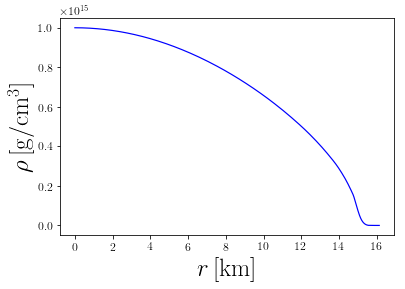

In [196]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1*b*1e-5,rho1*Sigma,color='blue',linewidth='1.2') 
#plt.yscale('log')
plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$\rho\,\rm{[g/cm^3]}$')
#plt.savefig('DProf_SLy.pdf', format='pdf', dpi=1000,bbox_inches="tight")
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

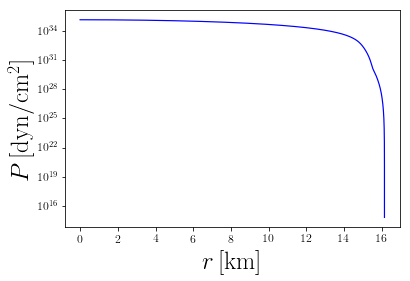

In [197]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1*b*1e-5,p1*pdim,'b-', linewidth=1.2) 
plt.yscale('log')
plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$P\,\rm{[dyn/cm^2]}$')
#plt.savefig('PProf_SLy.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

In [202]:
k=5 #orden del spline
s=1e-6 #factor de suavizamiento
rhos=interpolate.UnivariateSpline(r1, rho1, k=k, s=s)
drho=interpolate.UnivariateSpline(r1, rho1, k=k, s=s).derivative(n=1)
ddrho=interpolate.UnivariateSpline(r1, rho1, k=k, s=s).derivative(n=2)

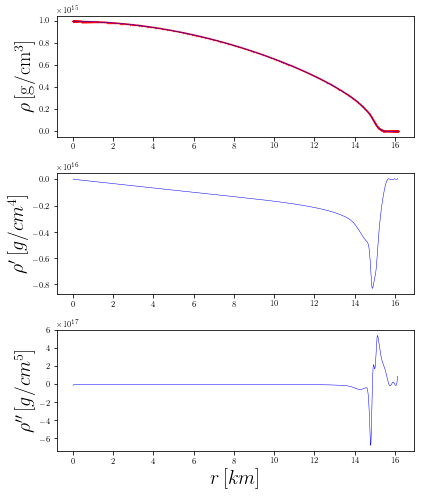

In [203]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure(figsize=[6.4,8])

plt.subplot(311)
plt.plot(r1*b*1e-5,rho1*Sigma,color='red',marker='o',markersize='0.4') 
plt.plot(r1*b*1e-5,rhos(r1)*Sigma,color='blue',linewidth='0.5') 
#plt.yscale('log')
#plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$\rho\,\rm{[g/cm^3]}$')

plt.subplot(312)
plt.plot(r1*b*1e-5,drho(r1)*Sigma,'b-', linewidth=0.5) 
#plt.yscale('log')
#plt.xlabel(r'$r\,[km]$')
plt.ylabel(r'$\rho^{\prime}\,[g/cm^4]$')

plt.subplot(313)
plt.plot(r1*b*1e-5,ddrho(r1)*Sigma,'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}\,[g/cm^5]$')
plt.xlabel(r'$r\,[km]$')

fig.subplots_adjust(hspace=0.3)

#plt.savefig('ddsSLy.pdf', format='pdf', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

# M-R and M-$\rho_c$ diagrams

Same integration routine but saving $M_{star}$, $R_{star}$ and $\rho_c$.

In [213]:
def staticMR(f,y0,r0,dr0):
    y=RK4Step(f,r0,[y0[0],y0[1]],dr0) #first step taken arbitrary (dr0) (for now)
    r=r0+dr0
    while rho_EoS(y[1])*Sigma > 2e+1 and y[1] > 0.0:
       # print('P=',y[1],'rho=',rho_EoS(y[1])*Sigma)
        dr=stepsize(y[0],y[1],TOV(r,[y[0],y[1]]),delta)
        y=RK4Step(f,r,[y[0],y[1]],dr)
        r=r+dr
    return [y[0]*mdim/Msun,r*b*1e-5,rho_EoS(y0[1])*Sigma] 

In [225]:
n=np.arange(14.5,15.5,0.01)
rhosc=10.0**n 
psc=P_EoS(rhosc/Sigma) 

In [226]:
MM=[];RR=[];rhorho=[]

for pc in psc:
    MRrho=staticMR(TOV,[m_0,pc],r0,1e-8)
   # print(MRrho)
    RR=RR+[MRrho[1]]
    MM=MM+[MRrho[0]]
    rhorho=rhorho+[MRrho[2]]

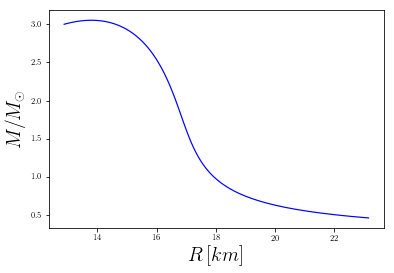

In [228]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
#plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()